<h1>
    <center>Dockless Vehicles Austin</center>
</h1>
<h2>
    <center>Team: Data Vaders</center>
    <h4>
        <center>Zarif Choudhury</center>
        <center>Vaidehi Durape</center>
        <center>Aashima Garg</center>
        <center>Aneesh Soni</center>
        <center>Brian Wilmarth</center>
    </h4>
</h2>

# Libraries Used

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import warnings
from datetime import date
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import cufflinks as cf
cf.go_offline()
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='aneeshsoni', api_key='e9PuzLMTHBbA5eVvZVNr')
warnings.filterwarnings('ignore')
mapbox_access_token = 'pk.eyJ1IjoiYW5lZXNoc29uaSIsImEiOiJjanZyOW1kemQwZnhwM3lueHhiZDE4ZTcwIn0.iywNpoytj-XU17BF4Tp_Fw'

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from IPython.display import HTML, display, IFrame

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
def generateBaseMap(default_location=[30.2672, -97.7431], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

# Load Data

In [3]:
dockless = pd.read_csv("./Data/Austin_Dockless_Vehicle_Trips.csv")

# Dockless Data

### Summary of Data
- 2,746,505 total trips recorded
    - 6/29/18 to 2/12/19
- Nearly 20% of all trips are under 200 meters

### Formatting and Cleaning Data

Filtered data based on range of a single charge
- Get rid of all non scooter data
- Scooter Range: 15/20 miles
- Bike Range: 50+ miles

Get rid of data outside of Austin
- 30.51436,-98.01118
- 30.10356,-98.01564
- 30.10504,-97.45843
- 30.51954,-97.45534

In [4]:
dockless['Start Time'] = pd.to_datetime(dockless['Start Time'], format='%m/%d/%Y %I:%M:%S %p')
dockless['End Time'] = pd.to_datetime(dockless['End Time'], format='%m/%d/%Y %I:%M:%S %p')
dockless['Modified Date'] = pd.to_datetime(dockless['End Time'], format='%m/%d/%Y %I:%M:%S %p')

dockless['Trip Distance (Miles)'] = (dockless['Trip Distance']/1000)*0.621371

dockless.rename(columns={'Trip Duration': 'Trip Duration (Seconds)', 'Trip Distance': 'Trip Distance (Meters)'}, inplace = True)
dockless.drop(dockless[dockless['Vehicle Type'] == 'bicycle'].index, inplace=True)
dockless.drop(dockless[dockless['Trip Distance (Meters)'] < 0].index, inplace=True)
dockless.drop(dockless[dockless['Trip Distance (Miles)'] > 75].index, inplace=True)

dockless.drop(dockless[dockless['Start Longitude'] < -98.01118].index, inplace=True)
dockless.drop(dockless[dockless['Start Latitude'] > 30.51436].index, inplace=True)
dockless.drop(dockless[dockless['Start Longitude'] > -97.45534].index, inplace=True)
dockless.drop(dockless[dockless['Start Latitude'] < 30.10504].index, inplace=True)

dockless.drop(dockless[dockless['End Longitude'] < -98.01118].index, inplace=True)
dockless.drop(dockless[dockless['End Latitude'] > 30.51436].index, inplace=True)
dockless.drop(dockless[dockless['End Longitude'] > -97.45534].index, inplace=True)
dockless.drop(dockless[dockless['End Latitude'] < 30.10504].index, inplace=True)

dockless['Month'] = pd.to_numeric(dockless['Month'])
dockless['Hour'] = pd.to_numeric(dockless['Hour'])
dockless['Day of Week'] = pd.to_numeric(dockless['Day of Week'])

dockless.dropna(inplace = True)

### Understanding Data

#### Correlation of Features

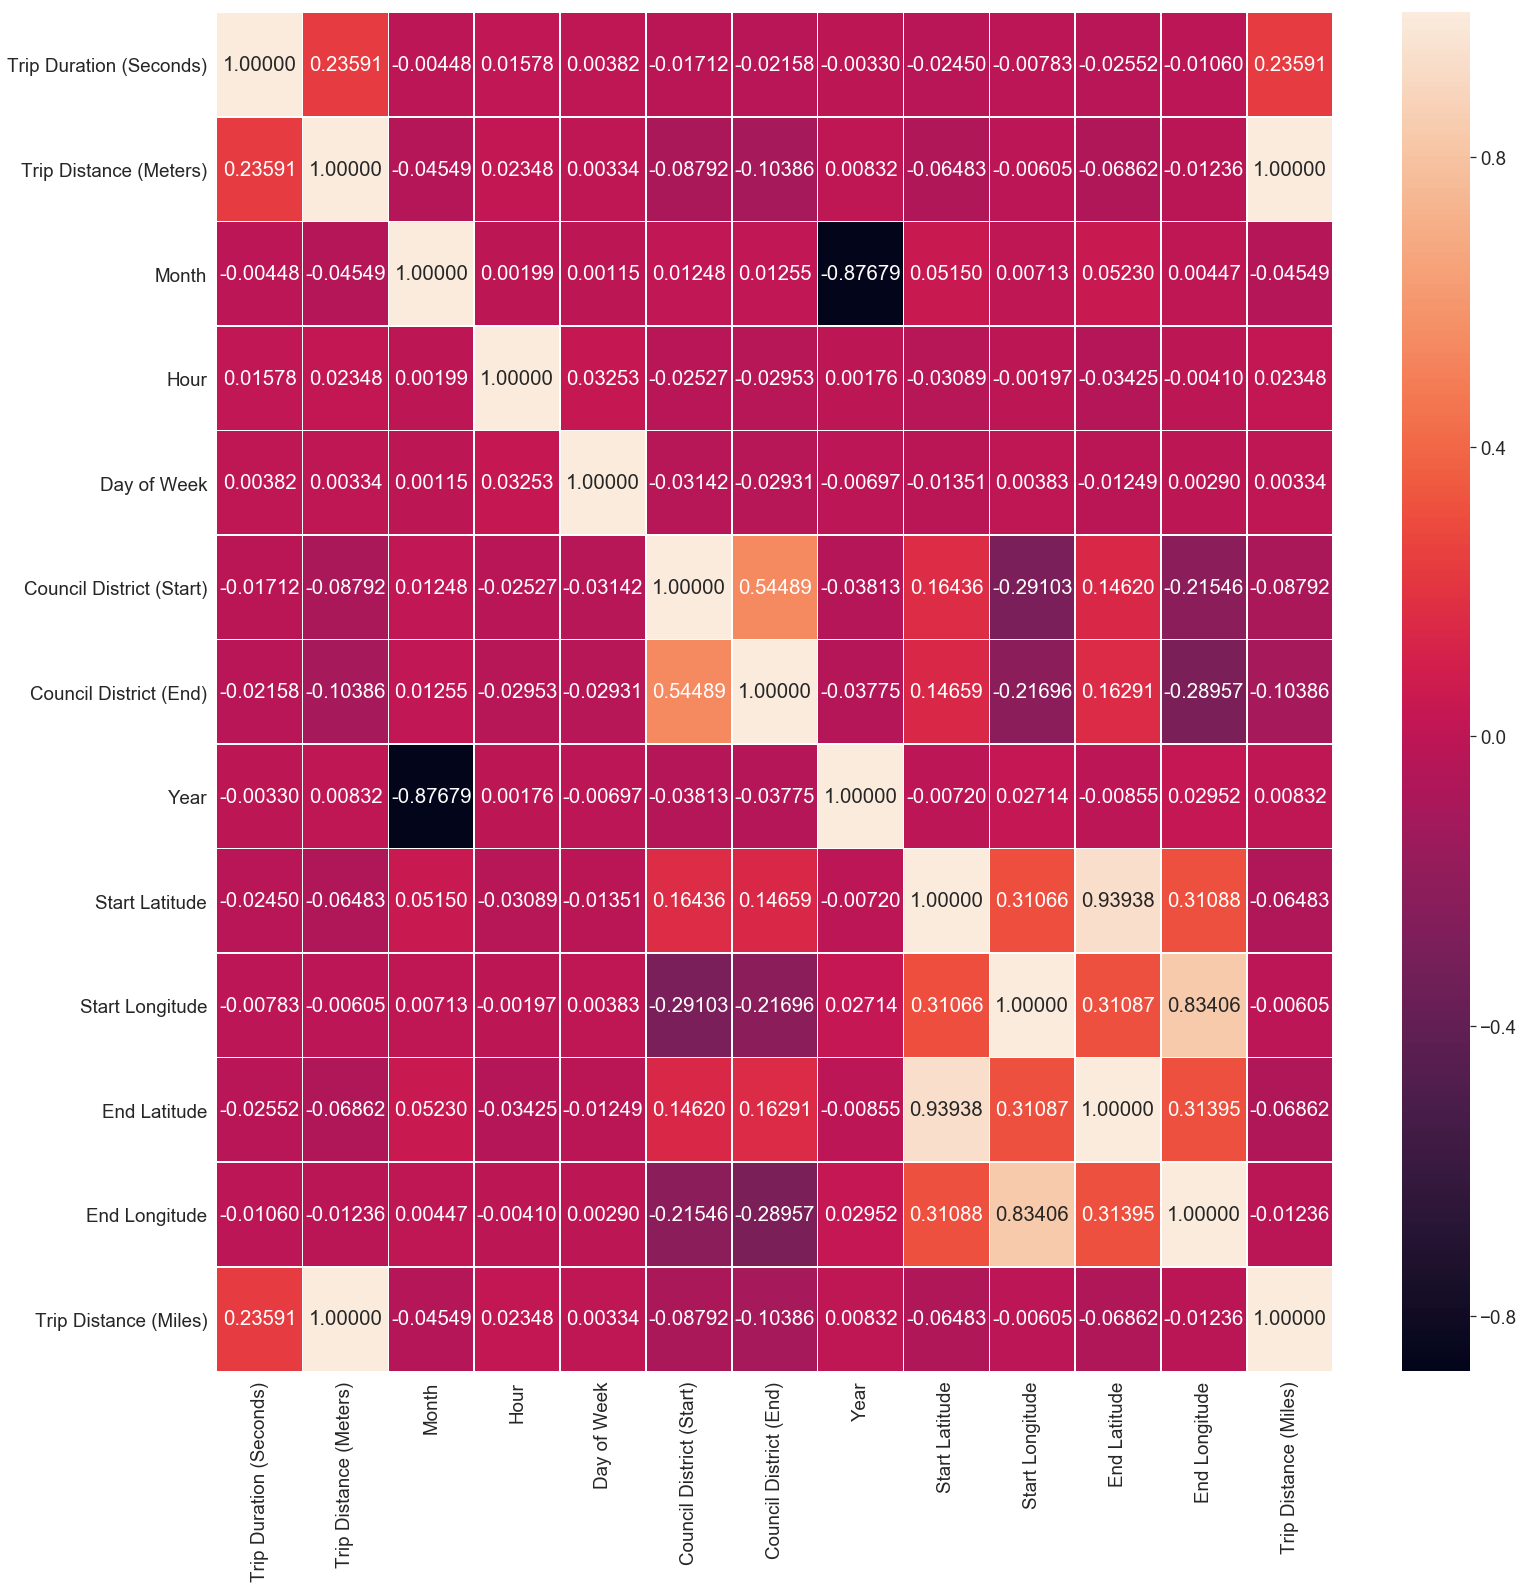

In [12]:
f, ax = plt.subplots(figsize=(25, 25))
sns.set(font_scale=1.7)
fig = sns.heatmap(dockless.corr(), annot=True, linewidths=.5, fmt= '.5f', ax = ax)
fig.figure.savefig('Correlation_Heatmap.png')

#### Dates

In [239]:
dockless.groupby(['Start Time'])
dockless.tail(1)

,ID,Device ID,Vehicle Type,Trip Duration (Seconds),Trip Distance (Meters),Start Time,End Time,Modified Date,Month,Hour,...,Council District (Start),Council District (End),Origin Cell ID,Destination Cell ID,Year,Start Latitude,Start Longitude,End Latitude,End Longitude,Trip Distance (Miles)
2746504,f12a9b38-4fb7-4ca7-95e4-f13ead5bdc46,ea158f7f-8822-45cb-821a-b0f0a33f90d6,scooter,688.0,1850.0,2019-02-12 04:45:00,2019-02-12 05:00:00,2019-02-12 05:00:00,2.0,4.0,...,9.0,10.0,13607,012980,2019.0,30.273,-97.76,30.282,-97.771,1.149536


#### Rides Per Day

In [13]:
start = date(2018,6,29)
end = date(2019,2,12)
days = (end - start).days

dockless_rides_per_day = len(dockless)/days

In [25]:
data = [['Scooters', dockless_rides_per_day], ['B-Cycle', 1181.769]] 
df = pd.DataFrame(data, columns = ['Mode of Transportation', 'Rides Per Day']) 

trace1 = go.Bar(
    x = df['Mode of Transportation'],
    y = df['Rides Per Day'],
    marker=dict(
        color=['rgb(18, 97, 160)', 'rgb(56, 149, 211)'])
)

data = [trace1]

layout = go.Layout(
    title='Average Rides Per Day',
    xaxis=dict(
        title='Mode of Transportation',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14
        )
    ),
    yaxis=dict(
        title='Rides Per Day',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)

plotly.offline.plot(data, filename='./Visualizations/Rides_Per_Day.html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Rides Per Day (Scooters vs B-Cycles)')

#### Trip Distance

In [6]:
trace1 = go.Histogram(
    x=dockless['Trip Distance (Meters)'],
    opacity=0.8,
    nbinsx = 1000,
    xbins=dict(
        start=0,
        end=7000
    )
)

data = [trace1]
layout = go.Layout(
            barmode='overlay',
            title='Trip Distance',
                xaxis=dict(
                    title='Trip Distance (Meters)',
                    titlefont=dict(
                        size=14,
                    ),

                ),
                yaxis=dict(
                    title='Trip Count',
                    titlefont=dict(
                        size=14,
                    )
                )
            )

plotly.offline.plot(data, filename='./Visualizations/Trip Distance (Meters).html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Trip Distance (Meters)')

#### Trip Distance Based on Starting Locations

Filter Data based on these boundaries

- Downtown
- South Congress and Zilker
- West Camous
    
https://codepen.io/jhawes/pen/ujdgK

#### Trip Data from Sept 2018 to Nov 2018

In [7]:
start_date = '2018-09-01'
end_date = '2018-11-30'

mask = (dockless['Start Time'] >= start_date) & (dockless['Start Time'] <= end_date)
dockless_accident = dockless.loc[mask]
dockless_accident.sort_values(by=['Start Time'], inplace=True, ascending=False)

In [8]:
trace1 = go.Histogram(
    x=dockless_accident['Trip Distance (Meters)'],
    opacity=0.8,
    nbinsx = 1000,
    xbins=dict(
        start=0,
        end=7000
    )
)

data = [trace1]
layout = go.Layout(
            barmode='overlay',
            title='Trip Distance',
                xaxis=dict(
                    title='Trip Distance (Meters)',
                    titlefont=dict(
                        size=14,
                    ),

                ),
                yaxis=dict(
                    title='Trip Count',
                    titlefont=dict(
                        size=14,
                    )
                )
            )

plotly.offline.plot(data, filename='./Visualizations/Trip Distance (Meters) - (Sep 2018 - Nov 2018).html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Trip Distance - (Sep 2018 - Nov 2018)')

In [9]:
trace1 = go.Histogram(
    x=dockless_accident['Trip Duration (Seconds)'],
    opacity=0.8,
    xbins=dict(
        start=0,
        end=3000
    )
)

data = [trace1]
layout = go.Layout(
            barmode='overlay',
            title='Trip Duration',
                xaxis=dict(
                    title='Trip Duration (Seconds)',
                    titlefont=dict(
                        size=14,
                    ),

                ),
                yaxis=dict(
                    title='Trip Count',
                    titlefont=dict(
                        size=14,
                    )
                )
            )

plotly.offline.plot(data, filename='./Visualizations/Trip Duration (Seconds) - (Sep 2018 - Nov 2018).html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Trip Duration - (Sep 2018 - Nov 2018)')

## Data Separated by Location

### Downtown

In [16]:
downtown = dockless.drop(dockless[dockless['Start Longitude'] < -97.76038].index, inplace=False)
downtown.drop(downtown[downtown['Start Latitude'] > 30.28093].index, inplace=True)
downtown.drop(downtown[downtown['Start Longitude'] > -97.73068].index, inplace=True)
downtown.drop(downtown[downtown['Start Latitude'] < 30.26143].index, inplace=True)

In [17]:
downtown['count'] = 1
base_map = generateBaseMap()
HeatMap(data=downtown[['Start Latitude', 'Start Longitude', 'count']].groupby(['Start Latitude', 'Start Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

### South Congress and Zilker

In [18]:
soco_zilker = dockless.drop(dockless[dockless['Start Longitude'] < -97.77637].index, inplace=False)
soco_zilker.drop(soco_zilker[soco_zilker['Start Latitude'] > 30.26697].index, inplace=True)
soco_zilker.drop(soco_zilker[soco_zilker['Start Longitude'] > -97.75097].index, inplace=True)
soco_zilker.drop(soco_zilker[soco_zilker['Start Latitude'] < 30.23983].index, inplace=True)

In [19]:
soco_zilker['count'] = 1
base_map = generateBaseMap()
HeatMap(data=soco_zilker[['Start Latitude', 'Start Longitude', 'count']].groupby(['Start Latitude', 'Start Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=14).add_to(base_map)
base_map

### West Campus

In [20]:
west_campus = dockless.drop(dockless[dockless['Start Longitude'] < -97.75261].index, inplace=False)
west_campus.drop(west_campus[west_campus['Start Latitude'] > 30.29784].index, inplace=True)
west_campus.drop(west_campus[west_campus['Start Longitude'] > -97.7424].index, inplace=True)
west_campus.drop(west_campus[west_campus['Start Latitude'] < 30.28212].index, inplace=True)

In [21]:
west_campus['count'] = 1
base_map = generateBaseMap()
HeatMap(data=west_campus[['Start Latitude', 'Start Longitude', 'count']].groupby(['Start Latitude', 'Start Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

In [22]:
start = date(2018,6,29)
end = date(2019,2,12)
days = (end - start).days

downtown_rides_per_day = len(downtown)/days
soco_zilker_rides_per_day = len(soco_zilker)/days
west_campus_rides_per_day = len(west_campus)/days

downtown_avg_distance = downtown['Trip Distance (Meters)'].mean()
soco_zilker_avg_distance = soco_zilker['Trip Distance (Meters)'].mean()
west_campus_avg_distance = west_campus['Trip Distance (Meters)'].mean()

downtown_avg_time = downtown['Trip Duration (Seconds)'].mean()
soco_zilker_avg_time = soco_zilker['Trip Duration (Seconds)'].mean()
west_campus_avg_time = west_campus['Trip Duration (Seconds)'].mean()

In [23]:
data = [['Downtown', downtown_rides_per_day], ['SoCo & Zilker', soco_zilker_rides_per_day],  ['West Campus', west_campus_rides_per_day]] 
df = pd.DataFrame(data, columns = ['Location', 'Rides Per Day']) 

trace1 = go.Bar(
    x = df['Location'],
    y = df['Rides Per Day'],
    marker=dict(
        color=['rgb(18, 97, 160)', 'rgb(56, 149, 211)',
               'rgb(88, 204, 237)'])
)

data = [trace1]

layout = go.Layout(
    title='Average Rides Per Day',
    xaxis=dict(
        title='Location',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14
        )
    ),
    yaxis=dict(
        title='Rides Per Day',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)

plotly.offline.plot(data, filename='./Visualizations/Rides_Per_Day.html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Rides Per Day')

In [269]:
data = [['Downtown', downtown_avg_distance], ['SoCo & Zilker', soco_zilker_avg_distance], ['West Campus', west_campus_avg_distance]] 
df = pd.DataFrame(data, columns = ['Location', 'Ride Distance']) 

trace1 = go.Bar(
    x = df['Location'],
    y = df['Ride Distance'],
    marker=dict(
        color=['rgb(18, 97, 160)', 'rgb(56, 149, 211)',
               'rgb(88, 204, 237)'])
)

data = [trace1]

layout = go.Layout(
    title='Average Ride Distance',
    xaxis=dict(
        title='Location',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14
        )
    ),
    yaxis=dict(
        title='Ride Distance (Meters)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.plot(data, filename='./Visualizations/Ride_Distance.html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename = 'Ride Distance')

In [24]:
data = [['Downtown', downtown_avg_time], ['SoCo & Zilker', soco_zilker_avg_time], ['West Campus', west_campus_avg_time]] 
df = pd.DataFrame(data, columns = ['Location', 'Ride Duration']) 

trace1 = go.Bar(
    x = df['Location'],
    y = df['Ride Duration'],
    marker=dict(
        color=['rgb(18, 97, 160)', 'rgb(56, 149, 211)',
               'rgb(88, 204, 237)'])
)

data = [trace1]

layout = go.Layout(
    title='Average Ride Duration',
    xaxis=dict(
        title='Location',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14
        )
    ),
    yaxis=dict(
        title='Ride Duration (Seconds)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.plot(data, filename='./Visualizations/Ride_Duration.html', auto_open = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'Ride Duration')

### Average Idle Time for Each Scooter

- see how long on average a scooter is idle in each location
- compare to all data
- not possible to compute given the data given to us was in intervals of 15 mins

In [ ]:
# Select all duplicate rows based on one column
same_downtown = downtown[downtown.duplicated(['Device ID', 'Month', 'Day of Week'])]
same_soco_zilker = soco_zilker[soco_zilker.duplicated(['Device ID', 'Month', 'Day of Week'])]
same_west_campus = west_campus[west_campus.duplicated(['Device ID', 'Month', 'Day of Week'])]

same_downtown = same_downtown.sort_values(['Device ID', 'Start Time', 'Hour'], ascending=[True, True, True])
same_soco_zilker = same_soco_zilker.sort_values(['Device ID', 'Start Time', 'Hour'], ascending=[True, True, True])
same_west_campus = same_west_campus.sort_values(['Device ID', 'Start Time', 'Hour'], ascending=[True, True, True])

same_downtown.reset_index(drop=True)
same_soco_zilker.reset_index(drop=True)
same_west_campus.reset_index(drop=True)